## Seinfeld Chatbot

In [15]:
# Standard imports
import pandas as pd
import numpy as np
import re
import pickle

# Visualization library
import seaborn as sns

# NLP library
from nltk.tokenize import word_tokenize

In [16]:
# Loading in entire Seinfeld script

df = pd.read_csv('scripts.csv', index_col=0)

In [17]:
df.head()

,Character,Dialogue,EpisodeNo,SEID,Season
0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0
2,GEORGE,Are you through?,1.0,S01E01,1.0
3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0


The dialogue has stage directions included, indicated by parentheses. I have decided to remove them to just model on pure dialogue.

In [18]:
# Remove parentheses

df['clean_dialogue'] = df['Dialogue'].str.replace(r"\(.*\)","")

In [19]:
# Seeing there is 10 dialogue cells that are NaNs

df.isna().sum()

Character          0
Dialogue          10
EpisodeNo          0
SEID               0
Season             0
clean_dialogue    10
dtype: int64

In [20]:
# Removing NaNs

df.dropna(inplace=True)

In [21]:
# Calculating the length of each line of dialogue

df['dialogue_len'] = df['Dialogue'].apply(lambda x: len(x))

In [22]:
# Calculating the word count of each line of dialogue

df['wordcount'] = df['clean_dialogue'].apply(lambda x: len(word_tokenize(x)))

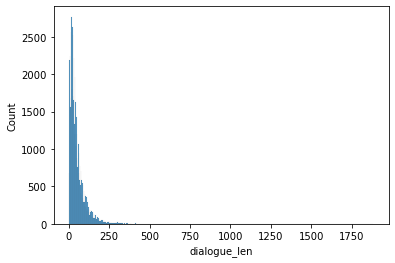

In [23]:
# Showing distribution of dialogue length in each line of dialogue

sns.histplot(data=df, x='dialogue_len');

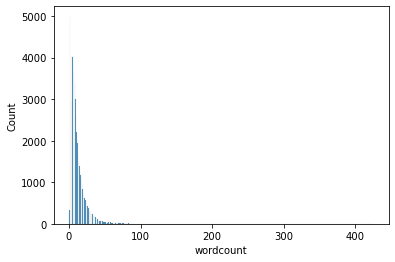

In [24]:
# Showing the distribution of word count in each line of dialogue

sns.histplot(data=df, x='wordcount');

There are a few lines of dialogue that are quite long! Most of these are probably Jerry's monologues at the beginning of the episodes. I will limit the length of lines to aid training. 

In [29]:
# Saving dataframe with dialogue length less than 50 characters

df = df[df['dialogue_len']< 50]

### Data Preparation

In this section the data is prepared for model. We need the data to be a list of lists with back and forth dialogue. 

In [34]:
# Creating a list of all dialogue

dialogue_list = list(df['clean_dialogue'])
dialogue_list[:5]

['Are you through?',
 'You do of course try on, when you buy?',
 'Oh, you dont recall?',
 'Mr. Seinfeld. Mr. Costanza.',
 'How come youre not doin the second show tomorrow?']

In [36]:
# Defining a data preparation function
def seq_prep(dialogue):
    '''
    This function takes in a list of dialogue and returns a list
    of lists in the appropriate format for our seq2seq model.
    '''
    dialogue_combos = []
    for i in range(len(dialogue)+ 1):
        try:
            dialogue_combos.append([dialogue[i], dialogue[i+1]])
        except:
            pass
    return dialogue_combos

In [38]:
data = seq_prep(dialogue_list)
data[:6]

[['Are you through?', 'You do of course try on, when you buy?'],
 ['You do of course try on, when you buy?', 'Oh, you dont recall?'],
 ['Oh, you dont recall?', 'Mr. Seinfeld. Mr. Costanza.'],
 ['Mr. Seinfeld. Mr. Costanza.',
  'How come youre not doin the second show tomorrow?'],
 ['How come youre not doin the second show tomorrow?',
  'Well, theres this uh, woman might be comin in.'],
 ['Well, theres this uh, woman might be comin in.', 'No, you didnt!']]

In [40]:
# Saving the prepared data as a pickle file
with open('./data/seq2seq_data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [41]:
# Building empty lists to hold sentences
input_docs = []
target_docs = []
# Building empty vocabulary sets
input_tokens = set()
target_tokens = set()

for line in data[:3000]:
  # Input and target sentences are separated by tabs
  input_doc, target_doc = line[0], line[1]
  # Appending each input sentence to input_docs
  input_docs.append(input_doc)
  # Splitting words from punctuation  
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
  # Redefine target_doc below 
  # and append it to target_docs:
  target_doc = '<START> ' + target_doc + ' <END>'
  target_docs.append(target_doc)
  
  # Now we split up each sentence into words
  # and add each unique word to our vocabulary set
  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    # Add your code here:
    if token not in input_tokens:
      input_tokens.add(token)
    
  for token in target_doc.split():
    # And here:
    if token not in target_tokens:
      target_tokens.add(token)



In [42]:
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))

# Create num_encoder_tokens and num_decoder_tokens:
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

# Finding the maximum 
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

In [43]:
# Creating four dictionaries

input_features_dict = dict(
    [(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict(
    (i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict(
    (i, token) for token, i in target_features_dict.items())


In [44]:
# Creating empty matricies

encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [45]:
print(f'Encoder Input Data Shape: {encoder_input_data.shape}')
print(f'Decoder Input Data Shape: {decoder_input_data.shape}')
print(f'Decoder Target Data Shape: {decoder_target_data.shape}')

Encoder Input Data Shape: (3000, 21, 2210)
Decoder Input Data Shape: (3000, 27, 2212)
Decoder Target Data Shape: (3000, 27, 2212)


In [46]:
for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):

  for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
    # Assign 1. for the current line, timestep, & word
    # in encoder_input_data:
    encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    # add in conditional for handling unknown tokens (when token is not in input features dict)

  for timestep, token in enumerate(target_doc.split()):

    decoder_input_data[line, timestep, target_features_dict[token]] = 1.
    if timestep > 0:

      decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

In [48]:
list(enumerate(zip(input_docs, target_docs)))[:13]

[(0,
  ('Are you through?',
   '<START> You do of course try on , when you buy ? <END>')),
 (1,
  ('You do of course try on, when you buy?',
   '<START> Oh , you dont recall ? <END>')),
 (2,
  ('Oh, you dont recall?', '<START> Mr . Seinfeld . Mr . Costanza . <END>')),
 (3,
  ('Mr. Seinfeld. Mr. Costanza.',
   '<START> How come youre not doin the second show tomorrow ? <END>')),
 (4,
  ('How come youre not doin the second show tomorrow?',
   '<START> Well , theres this uh , woman might be comin in . <END>')),
 (5,
  ('Well, theres this uh, woman might be comin in.',
   '<START> No , you didnt ! <END>')),
 (6, ('No, you didnt!', '<START> Ha . <END>')),
 (7, ('Ha.', '<START> So , you know , what , what happened ? <END>')),
 (8,
  (' So, you know, what, what happened?',
   '<START> Oh , nothing happened , you know , but is was great . <END>')),
 (9,
  ('Oh, nothing happened, you know, but is was great.',
   '<START> Oh , nothing happened , but it was . . . <END>')),
 (10, ('Oh, nothing hap

In [49]:
list(enumerate(re.findall(r"[\w]+|[^\s\s]", input_doc)))

[(0, 'Of'), (1, 'what'), (2, '?')]

In [50]:
list(enumerate(word_tokenize(input_doc)))

[(0, 'Of'), (1, 'what'), (2, '?')]

In [53]:
#from preprocessing import num_encoder_tokens, num_decoder_tokens, decoder_target_data, encoder_input_data, decoder_input_data, decoder_target_data, max_encoder_seq_length, max_decoder_seq_length
from tensorflow import keras
# Add Dense to the imported layers
from tensorflow.keras.layers import Input, LSTM, Dense, Masking
from tensorflow.keras.models import Model
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

latent_dim = 256
batch_size = 200
epochs = 100

# Encoder training setup
encoder_inputs = Input(shape=(None, num_encoder_tokens))

encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder training setup:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,_ ,_ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

## The code below was used to train my training model. Implemented in Google Colab

In [54]:
# Building the training model:
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')

history = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    validation_split = 0.2)

training_model.save('/Users/alexander.fioto/Models/training_model.h5')

Epoch 1/100
12/12 [==============================] - 9s 719ms/step - loss: 1.6054 - accuracy: 0.0358 - val_loss: 1.4070 - val_accuracy: 0.0415
Epoch 2/100
12/12 [==============================] - 8s 667ms/step - loss: 1.3265 - accuracy: 0.0446 - val_loss: 1.4024 - val_accuracy: 0.0450
Epoch 3/100
12/12 [==============================] - 8s 673ms/step - loss: 1.3029 - accuracy: 0.0476 - val_loss: 1.4025 - val_accuracy: 0.0428
Epoch 4/100
12/12 [==============================] - 8s 665ms/step - loss: 1.2879 - accuracy: 0.0480 - val_loss: 1.4151 - val_accuracy: 0.0457
Epoch 5/100
12/12 [==============================] - 8s 671ms/step - loss: 1.2789 - accuracy: 0.0491 - val_loss: 1.4168 - val_accuracy: 0.0387
Epoch 6/100
12/12 [==============================] - 8s 670ms/step - loss: 1.2708 - accuracy: 0.0487 - val_loss: 1.4185 - val_accuracy: 0.0449
Epoch 7/100
12/12 [==============================] - 8s 681ms/step - loss: 1.2635 - accuracy: 0.0515 - val_loss: 1.4218 - val_accuracy: 0.0494

In [ ]:
pwd

In [81]:
#from preprocessing import input_features_dict, target_features_dict, reverse_input_features_dict, reverse_target_features_dict, max_decoder_seq_length, input_docs, target_docs, input_tokens, target_tokens, max_encoder_seq_length
#from training_model import decoder_inputs, decoder_lstm, decoder_dense, encoder_input_data, num_decoder_tokens, num_encoder_tokens

from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model, load_model


# training_model = load_model('training_model.h5')

# encoder_inputs = training_model.input[0]
# encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
# encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [63]:
def decode_sequence(test_input):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(test_input)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  # Populate the first token of target sequence with the start token.
  target_seq[0, 0, target_features_dict['<START>']] = 1.

  # Sampling loop for a batch of sequences
  # (to simplify, here we assume a batch of size 1).
  decoded_sentence = ''

  stop_condition = False
  while not stop_condition:
    # Run the decoder model to get possible 
    # output tokens (with probabilities) & states
    output_tokens, hidden_state, cell_state = decoder_model.predict(
      [target_seq] + states_value)

    # Choose token with highest probability
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = reverse_target_features_dict[sampled_token_index]
    decoded_sentence += " " + sampled_token

    # Exit condition: either hit max length
    # or find stop token.
    if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
      stop_condition = True

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.

    # Update states
    states_value = [hidden_state, cell_state]

  return decoded_sentence

In [64]:
decode_sequence('What are you doing?')

IndexError: list index out of range

In [82]:
class ChatBot:
    negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")


    exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop", 'end')

    def start_chat(self):
        user_response = input("Hi, I'm a chatbot trained on dialog from Seinfeld. Would you like to chat with me?\n")
    
        if user_response.lower() in self.negative_responses:
            print("Ok, have a great day!")
            return
    
        user_response = input('Great! I am still a work in progress. Try using a lot of different words when chatting with me. Ok, what do you want to talk about?')
    
        self.chat(user_response)
  
    def chat(self, reply):
        while not self.make_exit(reply):
            reply = input(self.generate_response(reply))
    

    def string_to_matrix(self, user_input):
        tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
        user_input_matrix = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
        for timestep, token in enumerate(tokens):
            if token in input_features_dict:
                user_input_matrix[0, timestep, input_features_dict[token]] = 1.

        return user_input_matrix

    def generate_response(self, user_input):
        input_matrix = self.string_to_matrix(user_input)
        states_value = encoder_model.predict(input_matrix)
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, target_features_dict['<START>']] = 1.0
    
        chatbot_response = ''

        stop_condition = False

        while not stop_condition:

            output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_token = reverse_target_features_dict[sampled_token_index]
            chatbot_response += " " + sampled_token

            if (sampled_token == '<END>' or len(chatbot_response) > max_decoder_seq_length):
                stop_condition = True

                target_seq = np.zeros((1, 1, num_decoder_tokens))
                target_seq[0, 0, sampled_token_index] = 1.

            if '<END>' in chatbot_response:
                chatbot_response = chatbot_response.replace('<END>', '')

            punctuations = [' ?', ' .', ' !', ' ,']            
            for punctuation in punctuations:
                if punctuation in chatbot_response:
                    chatbot_response = chatbot_response.replace(punctuation, punctuation[-1])


            states_value = [hidden_state, cell_state]

        return chatbot_response
  
    def make_exit(self, reply):
        for exit_command in self.exit_commands:
            if exit_command in reply:
                print("Ok, have a great day!")
                return True
            
        return False

In [83]:
chat = ChatBot()

In [84]:
chat.start_chat()

Hi, I'm a chatbot trained on dialog from Seinfeld. Would you like to chat with me?
 Yes
Great! I am still a work in progress. Try using a lot of different words when chatting with me. Ok, what do you want to talk about? What is your favorite food


KeyboardInterrupt: Interrupted by user